<a href="https://colab.research.google.com/github/nishitjain97/Example-Based-Neural-Machine-Translation-System/blob/master/3_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive on Colab
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from six.moves import range
from six.moves.urllib.request import urlretrieve
import pandas as pd
import pickle

In [0]:
filename = '/content/drive/My Drive/Hindi Dataset/mono_cleaned.hi'

In [5]:
def read_data(filename):
  with open(filename, 'r') as f:
    text = tf.compat.as_str(f.readlines()[0])
  return text.strip().split(' ')

words = read_data(filename)
print("Data size %d" % len(words))

Data size 94644789


In [9]:
len(set(words))

1112832

In [10]:
vocabulary_size = 500000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()
    
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)
    
    count[0][1] = unk_count
    
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print("Most common words (+UNK)", count[:5])
print("Sample data", data[:10])
del words

Most common words (+UNK) [['UNK', 612833], ('के', 3432415), ('है', 2922224), ('में', 2541126), ('की', 2145907)]
Sample data [28, 3204, 7, 48234, 4198, 8, 479, 478, 64236, 48234]


In [11]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    
    for i in range(batch_size // num_skips):
        target = skip_window
        targets_to_avoid = [skip_window]
        
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span-1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print("Data:", [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print("\nwith num_skips = %d and skip_window = %d:" % (num_skips, skip_window))
    print("    batch:", [reverse_dictionary[bi] for bi in batch])
    print("    labels:", [reverse_dictionary[di] for di in labels.reshape(8)])

Data: ['अपने', 'अनुप्रयोग', 'को', 'पहुंचनीयता', 'व्यायाम', 'का', 'लाभ', 'दें']

with num_skips = 2 and skip_window = 1:
    batch: ['अनुप्रयोग', 'अनुप्रयोग', 'को', 'को', 'पहुंचनीयता', 'पहुंचनीयता', 'व्यायाम', 'व्यायाम']
    labels: ['को', 'अपने', 'पहुंचनीयता', 'अनुप्रयोग', 'को', 'व्यायाम', 'का', 'पहुंचनीयता']

with num_skips = 4 and skip_window = 2:
    batch: ['को', 'को', 'को', 'को', 'पहुंचनीयता', 'पहुंचनीयता', 'पहुंचनीयता', 'पहुंचनीयता']
    labels: ['अनुप्रयोग', 'अपने', 'व्यायाम', 'पहुंचनीयता', 'को', 'अनुप्रयोग', 'व्यायाम', 'का']


In [12]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                                    labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))
    
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.cast instead.


In [13]:
num_steps = 200001
loss_list = list()

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    average_loss = 0
    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset:batch_data, train_labels:batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            
            print("Average loss at step %d: %f" % (step, average_loss))
            loss_list.append(average_loss)
            
            average_loss = 0
        
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.164712
Nearest to काम: लग्जमबर्ग, सिंपली, रूपरेखा, समंदाल, ह्रासप्राप्त, हटाओगे, आर्कुट, फाडिया,
Nearest to रहे: साझीदारों, ऑक्सफ़ॉर्ड, जमकारान, अंडरराइटर्स, येऊ, प्रसंगे, प्रतिक्षालय, ढिक,
Nearest to होने: पंगेरे, शानशाई, क्रूर, महामार्ग, तीते, चॅनेल्स, पहुंचनेवाला, यूरिको,
Nearest to लेकिन: रोडशो, मुहल्लेके, बालचन्द्र, धार्मिकस्थलों, नॉस्ट्रो, राजशुक, मीलीयन, समानधर्मो,
Nearest to अपने: रुआंसू, गजटेड, पॉजीशन, पष्ठभूमि, पेम्पलेट्स, बुर्जुवा, मन्थान, द्घुमाने,
Nearest to तुम: नवाता, ताम्बूल, शहरजाद, तालाबंदियां, बिष्ठायुक्त, बुलडॉग्स, ाूब, छप्पथर,
Nearest to ने: सुएसाइड, विनमृता, त्रियोले, चॉल, तबल, कार्पोरेटर, प्लांकट्स, मॉरिन,
Nearest to पर: एससीआर, भूमिप्रजाति, ओजस्वी, सरलीकृत, पहनाओगे, गोंत, अहमदाबादत्नरिलायंस, रुपम,
Nearest to उन्हें: जैरिएट्रिक, बीतीरात, फ़ारुक़, प्रेरम, ब्रेनन, चैंदा, पहूँचाने, निर्लज्जता,
Nearest to वे: प्रोसीक्यूशन, गौरव्, प्रदेशिक, दयाभावको, पदनामसंपर्क, ऑप्रेटिंग, अरमिनियाइ, तिरूप्परांकुनरम,
Nearest to फिर: कंडोलिया, संभ

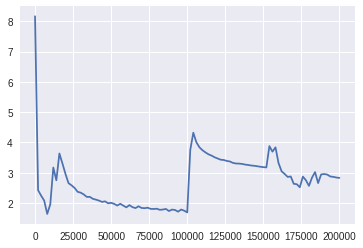

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(range(0, 200001, 2000)), loss_list)
plt.show()

In [0]:
output = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

In [0]:
with open('/content/drive/My Drive/Hindi Dataset/embeddings.hi', 'wb') as f:
    pickle.dump(output, f)